In [48]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from dotenv import load_dotenv

load_dotenv()

ODS_API_KEY = os.getenv("ODS_API_KEY")
ODS_PAYSAGE_KEY = os.getenv("ODS_PAYSAGE_KEY")

AFFILIATION_MATCHER_API = f"{os.getenv('AFFILIATION_MATCHER_URL')}/match"
AFFILIATION_MATCHER_API_LOCAL = "http://localhost:5004/match"
AFFILIATION_MATCHER_LIST_API = "http://localhost:5004/match_list"
AFFILIATION_MATCHER_LIST_TASK_API = "http://localhost:5004/tasks"

COL_AFFILIATION_IS_MATCH = "affiliation_is_match"
COL_AFFILIATION_STR = "affiliation_string"

MATCH_TYPE = "paysage"

FILE_PATH = "../_data/paysage_match_list_paysage.json"

In [49]:
# api/match
def affiliation_get_matches(affiliation: str, year=None, local=False):
  if not isinstance(affiliation, str):
    return None
  
  body = {"type": MATCH_TYPE, "query": affiliation}
  if year:
    body["year"] = year
  
  url = AFFILIATION_MATCHER_API_LOCAL if local else AFFILIATION_MATCHER_API
  

  res=requests.post(url=url, json=body)

  if res.status_code == 202:
    return res.json()
  
  raise Exception("ERROR_{res.status_code}")

# indice find
def elastic_percolate(indice, query):
  url = "http://localhost:9200"
  body = { "query": {"percolate": {"field": "query", "document": { "content": query}}}}
  res = requests.post(f"{url}/{indice}/_search", json=body)
  return res.json()

In [50]:
df = pd.read_json(FILE_PATH)
df.head(2)

,identifiant_rnsr,identifiant_interne,etat,date_fermeture,sigle,uo_lib,uo_lib_officiel,adresse_uai,lieu_dit_uai,boite_postale_uai,code_postal_uai,localite_acheminement_uai,pays_etranger_acheminement,affiliation_string,affiliation_string_off,affiliation_match,affiliation_match_off,affiliation_is_match,affiliation_is_match_off
0,None,7CYWd,False,2019.0,UNS,Université Nice - Sophia-Antipolis,Université de Nice,28 avenue de Valrose,GRAND CHATEAU,None,06108,Nice CEDEX 2,France,"Université Nice - Sophia-Antipolis, 28 avenue ...","Université de Nice, 28 avenue de Valrose, GRAN...",[7CYWd],[7CYWd],MATCH.ID_MATCH,MATCH.ID_MATCH
1,None,542Id,True,NaN,UT1,Université Toulouse Capitole,Université Toulouse-I,2 rue du Doyen-Gabriel-Marty,None,None,31042,Toulouse CEDEX,France,"Université Toulouse Capitole, 2 rue du Doyen-G...","Université Toulouse-I, 2 rue du Doyen-Gabriel-...","[gap5Q, 542Id]",[542Id],MATCH.ID_MATCH,MATCH.ID_MATCH


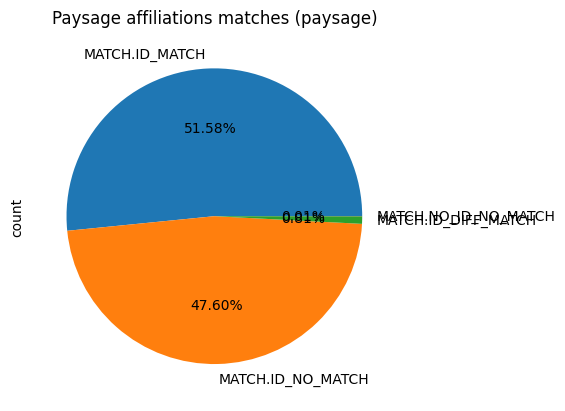

In [51]:
df[COL_AFFILIATION_IS_MATCH].value_counts().plot.pie(title=f"Paysage affiliations matches ({MATCH_TYPE})", autopct="%.02f%%")
plt.show()

DIFF_MATCH

In [57]:
df_diff_match = df[df[COL_AFFILIATION_IS_MATCH] == "MATCH.ID_DIFF_MATCH"]
len(df_diff_match)

64

In [56]:
test = df_diff_match.iloc[0]
display(test)
print(test[COL_AFFILIATION_STR])
affiliation_get_matches(test[COL_AFFILIATION_STR], local=True)

identifiant_rnsr                                                           None
identifiant_interne                                                        None
etat                                                                      False
date_fermeture                                                              NaN
sigle                                                                      None
uo_lib                                             CROUS de l'académie de Paris
uo_lib_officiel                                    CROUS de l'académie de Paris
adresse_uai                                          39 avenue Georges Bernanos
lieu_dit_uai                                                               None
boite_postale_uai                                                          None
code_postal_uai                                                           75005
localite_acheminement_uai                                                 Paris
pays_etranger_acheminement              

CROUS de l'académie de Paris, 39 avenue Georges Bernanos, 75005, Paris, France


ConnectionError: HTTPConnectionPool(host='localhost', port=5004): Max retries exceeded with url: /match (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022BB0182110>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

NO MATCH

In [ ]:
df_no_match = df[df[COL_AFFILIATION_IS_MATCH] == "MATCH.ID_NO_MATCH"]
len(df_no_match)

2181

In [ ]:
test = df_no_match.iloc[13]
display(test)
print(test[COL_AFFILIATION_STR])
affiliation_get_matches(test[COL_AFFILIATION_STR], local=True)

identifiant_rnsr                                                           None
identifiant_interne                                                       5zvLV
etat                                                                       True
date_fermeture                                                              NaN
sigle                                                                      None
uo_lib                                          Fondation partenariale Polytech
uo_lib_officiel                                 Fondation partenariale Polytech
adresse_uai                                          58 boulevard Charles Livon
lieu_dit_uai                                                               None
boite_postale_uai                                                          None
code_postal_uai                                                           13007
localite_acheminement_uai                                             Marseille
pays_etranger_acheminement              

Fondation partenariale Polytech, 58 boulevard Charles Livon, 13007, Marseille, France


{'enriched_results': [],
 'index_date': '20240409',
 'other_ids': [],
 'results': [],
 'version': '0.1.28'}

TEST

In [ ]:
indice = "matcher-20240409134004_paysage_name_txt"
query = "Alliance Sorbonne Université, 75006, PARIS, France"
elastic_percolate(indice, query)

{'took': 80,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7, 'relation': 'eq'},
  'max_score': 0.39229372,
  'hits': [{'_index': 'matcher-20240409134004_paysage_name_txt',
    '_type': '_doc',
    '_id': '7eUXw44Bz0HHf6WJRuSe',
    '_score': 0.39229372,
    '_source': {'paysages': ['kvciR'],
     'country_alpha2': ['fr'],
     'query': {'match': {'content': {'query': 'Université Paris-Sorbonne',
        'analyzer': 'heavy_fr',
        'minimum_should_match': '-10%'}}}},
    'fields': {'_percolator_document_slot': [0]}},
   {'_index': 'matcher-20240409134004_paysage_name_txt',
    '_type': '_doc',
    '_id': '7uUXw44Bz0HHf6WJRuSe',
    '_score': 0.39229372,
    '_source': {'paysages': ['kvciR'],
     'country_alpha2': ['fr'],
     'query': {'match': {'content': {'query': 'Paris-Sorbonne University',
        'analyzer': 'heavy_fr',
        'minimum_should_match': '-10%'}}}},
    'fields': {'_percolator_document_sl